<a href="https://colab.research.google.com/github/Dureduran/DataScience/blob/main/Project_Toronto_Clustering_Neighbourhood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Segmenting and Clustering Neighborhoods in Toronto

## Libraries

In [8]:
!pip install lxml bs4 html5lib
!conda update -n base -c defaults conda
import pandas as pd
import numpy as np
#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

/bin/bash: conda: command not found


## Scraping and Cleaning the Data

In [14]:
to_hoods = pd.read_html('https://en.wikipedia.org/w/index.php?title=List_of_postal_codes_of_Canada:_M&oldid=1011037969')[0]

In [15]:
to_hoods = to_hoods[to_hoods['Borough']!='Not assigned']

In [16]:
to_hoods['Neighbourhood']=np.where(to_hoods['Neighbourhood']=='Not assigned',to_hoods['Borough'],to_hoods['Neighbourhood']) 
#using np.where(condition,y,n) to replace any 'Not assigned' values in the Neighbourhood column with the values in the Borough column

In [17]:
to_hoods = to_hoods.rename(columns={'Neighbourhood' : 'Neighborhood'}) #converting the canadian spelling to american to avoid conflicts

In [18]:
to_hoods.head()

,Postal Code,Borough,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [19]:
to_hoods.shape

(103, 3)

In [20]:
to_hoods = to_hoods.groupby(['Postal Code'], sort=False).agg(', '.join)

In [21]:
to_hoods.reset_index(drop= False)

,Postal Code,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
99,M4Y,Downtown Toronto,Church and Wellesley
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


## Coordiantes for each neighborhood

In [23]:
lat_lng_coords = pd.read_csv('https://cocl.us/Geospatial_data')
lat_lng_coords.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


## Latitude and Longitude values

In [24]:
to_hoods_coords = pd.merge(to_hoods,lat_lng_coords,on='Postal Code')
to_hoods_coords

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


In [25]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


In [26]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(to_hoods_coords['Latitude'], to_hoods_coords['Longitude'], to_hoods_coords['Borough'], to_hoods_coords['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

## API

In [27]:
CLIENT_ID = 'xxx' # your Foursquare ID
CLIENT_SECRET = 'xxx' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

## Toronto has sprawling neighborhoods therefore the radius is set to 1000m

In [28]:
def getNearbyVenues(names, latitudes, longitudes, radius= 1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

## Results

In [29]:
toronto_venues = getNearbyVenues(names=to_hoods_coords['Neighborhood'],
                                   latitudes=to_hoods_coords['Latitude'],
                                   longitudes=to_hoods_coords['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

In [30]:
print(toronto_venues.shape)
toronto_venues.head()

(4766, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
1,Parkwoods,43.753259,-79.329656,Bruno's valu-mart,43.746143,-79.324630,Grocery Store
2,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
3,Parkwoods,43.753259,-79.329656,A&W,43.760643,-79.326865,Fast Food Restaurant
4,Parkwoods,43.753259,-79.329656,Shoppers Drug Mart,43.745315,-79.325800,Pharmacy


## Number of venues per neighborhood

In [31]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,45,45,45,45,45,45
"Alderwood, Long Branch",25,25,25,25,25,25
"Bathurst Manor, Wilson Heights, Downsview North",28,28,28,28,28,28
Bayview Village,17,17,17,17,17,17
"Bedford Park, Lawrence Manor East",42,42,42,42,42,42
...,...,...,...,...,...,...
"Willowdale, Willowdale West",10,10,10,10,10,10
Woburn,9,9,9,9,9,9
Woodbine Heights,29,29,29,29,29,29


In [33]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 321 uniques categories.


## Preparing the data for clustering by running one hot encoding

In [34]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Zoo,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,...,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Tree,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [36]:
toronto_onehot.shape

(4766, 321)

## Top 5 venue types in each neighborhood

In [37]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Zoo,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,American Restaurant,Amphitheater,Animal Shelter,Aquarium,Arcade,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,...,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Toy / Game Store,Track,Trail,Train Station,Tree,Turkish Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.000000,0.0,0.0,0.0,0.0,0.022222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.044444,0.022222,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.022222,0.0,0.0,0.0,0.044444,0.0,0.022222,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0
1,"Alderwood, Long Branch",0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.04000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.040000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.071429,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.035714,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.035714,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0
3,Bayview Village,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.000000,0.117647,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.058824,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.000000,0.0,0.0,0.0,0.0,0.023810,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.02381,0.023810,0.047619,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.02381,0.000000,0.0,0.0,0.0,0.000000,0.0,0.023810,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.023810,0.0,0.0,0.0,0.0,0.02381,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.02381,0.0,0.0,0.0,0.0,0.0,0.0,0.02381,0.02381,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,"Willowdale, Willowdale West",0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.100000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.00000,0.000000,0.0,0.0,0.0,0.100000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0
94,Woburn,0.0,0.000000,0

In [41]:
toronto_grouped.shape

(98, 321)

In [42]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                  venue  freq
0    Chinese Restaurant  0.16
1  Caribbean Restaurant  0.04
2           Supermarket  0.04
3           Pizza Place  0.04
4                Bakery  0.04


----Alderwood, Long Branch----
               venue  freq
0     Discount Store  0.12
1        Pizza Place  0.08
2           Pharmacy  0.08
3               Park  0.08
4  Convenience Store  0.04


----Bathurst Manor, Wilson Heights, Downsview North----
         venue  freq
0         Bank  0.07
1  Coffee Shop  0.07
2         Park  0.07
3  Bridal Shop  0.04
4  Gas Station  0.04


----Bayview Village----
           venue  freq
0           Bank  0.12
1  Grocery Store  0.12
2    Gas Station  0.12
3   Intersection  0.12
4           Café  0.06


----Bedford Park, Lawrence Manor East----
                  venue  freq
0           Coffee Shop  0.07
1           Pizza Place  0.05
2    Italian Restaurant  0.05
3                  Bank  0.05
4  Fast Food Restaurant  0.05


----Berczy Park----
             

In [43]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

## 10 most common venues per neighborhood

In [44]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Pizza Place,Bakery,Shopping Mall,Caribbean Restaurant,Supermarket,Dim Sum Restaurant,Pool,Sri Lankan Restaurant,Latin American Restaurant
1,"Alderwood, Long Branch",Discount Store,Pharmacy,Pizza Place,Park,Trail,Skating Rink,Moroccan Restaurant,Shopping Mall,Liquor Store,Donut Shop
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Park,Coffee Shop,Ski Area,Sushi Restaurant,Fried Chicken Joint,Community Center,Bridal Shop,Middle Eastern Restaurant,Ski Chalet
3,Bayview Village,Grocery Store,Bank,Intersection,Gas Station,Shopping Mall,Restaurant,Japanese Restaurant,Café,Trail,Chinese Restaurant
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Pizza Place,Bank,Italian Restaurant,Restaurant,Sandwich Place,Fast Food Restaurant,Skating Rink,Intersection,Sushi Restaurant


In [45]:
neighborhoods_venues_sorted.shape

(98, 11)

## Optimal K value using the Elbow Method

In [46]:
distortions = []
K = range(1,9)
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(toronto_grouped_clustering)
    distortions.append(kmeans.inertia_)

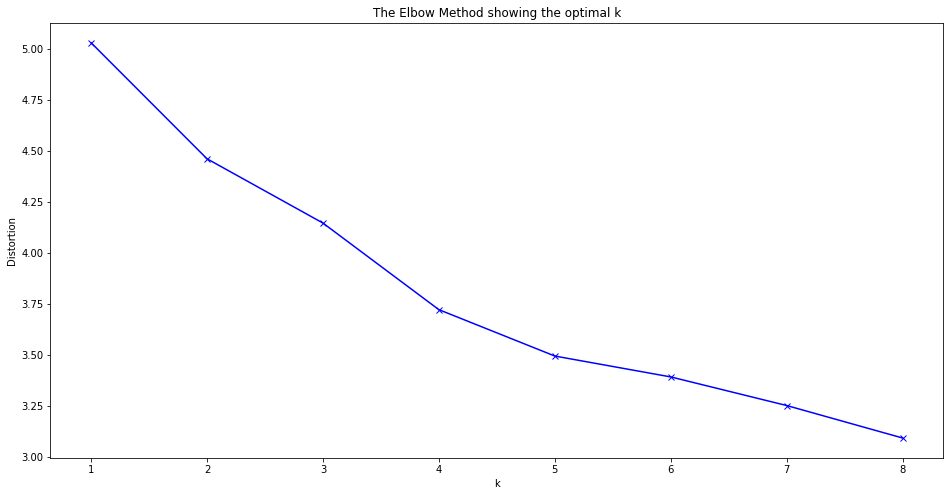

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

## KMean analysis using k=4

In [48]:
# set number of clusters
kclusters = 4

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([0, 1, 1, 1, 0, 0, 0, 0, 0, 0], dtype=int32)

## Removing neighborhoods that do not contain any venues

In [49]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = to_hoods_coords

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

toronto_merged.head() # check the last columns!

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.753259,-79.329656,1.0,Park,Shopping Mall,Bus Stop,Pharmacy,Tennis Court,Supermarket,Caribbean Restaurant,Laundry Service,Café,Chinese Restaurant
1,M4A,North York,Victoria Village,43.725882,-79.315572,1.0,Coffee Shop,Hockey Arena,Men's Store,Lounge,Golf Course,Grocery Store,Gym / Fitness Center,Sporting Goods Shop,Pizza Place,Portuguese Restaurant
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.0,Coffee Shop,Pub,Sushi Restaurant,Restaurant,Café,Italian Restaurant,Pizza Place,Sandwich Place,Bakery,Park
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,0.0,Clothing Store,Fast Food Restaurant,Furniture / Home Store,Coffee Shop,Restaurant,Miscellaneous Shop,Sushi Restaurant,Fried Chicken Joint,Vietnamese Restaurant,Dessert Shop
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0.0,Sushi Restaurant,Coffee Shop,Japanese Restaurant,Park,Pizza Place,Café,Diner,Dessert Shop,Dance Studio,Cosmetics Shop


In [50]:
toronto_merged[toronto_merged['Cluster Labels'].isna()]

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
95,M1X,Scarborough,Upper Rouge,43.836125,-79.205636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
toronto_merged.dropna(subset = ["Cluster Labels"], inplace=True)

## Map

In [52]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
#rainbow = ['blue', 'orange', 'red', 'yellow', 'black', 'cadetblue']
# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [53]:
map_clusters.save("map_clusters.html")

## Outlier (Suburban neighborhood near highway junction)

In [54]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"Regent Park, Harbourfront",0.0,Coffee Shop,Pub,Sushi Restaurant,Restaurant,Café,Italian Restaurant,Pizza Place,Sandwich Place,Bakery,Park
3,"Lawrence Manor, Lawrence Heights",0.0,Clothing Store,Fast Food Restaurant,Furniture / Home Store,Coffee Shop,Restaurant,Miscellaneous Shop,Sushi Restaurant,Fried Chicken Joint,Vietnamese Restaurant,Dessert Shop
4,"Queen's Park, Ontario Provincial Government",0.0,Sushi Restaurant,Coffee Shop,Japanese Restaurant,Park,Pizza Place,Café,Diner,Dessert Shop,Dance Studio,Cosmetics Shop
6,"Malvern, Rouge",0.0,Fast Food Restaurant,Trail,Home Service,Arts & Crafts Store,Spa,Martial Arts School,Bus Station,Supermarket,Caribbean Restaurant,Bank
7,Don Mills,0.0,Restaurant,Gym,Coffee Shop,Japanese Restaurant,Supermarket,Sandwich Place,Asian Restaurant,Pizza Place,Sporting Goods Shop,Burger Joint
9,"Garden District, Ryerson",0.0,Japanese Restaurant,Coffee Shop,Café,Sushi Restaurant,Gastropub,Restaurant,Italian Restaurant,Diner,Theater,Middle Eastern Restaurant
12,"Rouge Hill, Port Union, Highland Creek",0.0,Breakfast Spot,Park,Playground,Burger Joint,Italian Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant
13,Don Mills,0.0,Restaurant,Gym,Coffee Shop,Japanese Restaurant,Supermarket,Sandwich Place,Asian Restaurant,Pizza Place,Sporting Goods Shop,Burger Joint
14,Woodbine Heights,0.0,Coffee Shop,Park,Café,Pizza Place,Skating Rink,Sandwich Place,Convenience Store,Beer Store,Thai Restaurant,Restaurant
15,St. James Town,0.0,Café,Coffee Shop,Restaurant,Italian Restaurant,Japanese Restaurant,Gym,Bakery,Beer Bar,Deli / Bodega,Gastropub


## Urban (Downtown + Airport + Univerities + Subway Line):

In [55]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Parkwoods,1.0,Park,Shopping Mall,Bus Stop,Pharmacy,Tennis Court,Supermarket,Caribbean Restaurant,Laundry Service,Café,Chinese Restaurant
1,Victoria Village,1.0,Coffee Shop,Hockey Arena,Men's Store,Lounge,Golf Course,Grocery Store,Gym / Fitness Center,Sporting Goods Shop,Pizza Place,Portuguese Restaurant
5,"Islington Avenue, Humber Valley Village",1.0,Pharmacy,Skating Rink,Grocery Store,Bakery,Golf Course,Café,Shopping Mall,Bank,Playground,Convenience Store
8,"Parkview Hill, Woodbine Gardens",1.0,Brewery,Bakery,Pizza Place,Flea Market,Intersection,Soccer Stadium,Fast Food Restaurant,Breakfast Spot,Gastropub,Bank
10,Glencairn,1.0,Grocery Store,Fast Food Restaurant,Gas Station,Coffee Shop,Park,Metro Station,Playground,Sushi Restaurant,Furniture / Home Store,Latin American Restaurant
11,"West Deane Park, Princess Gardens, Martin Grov...",1.0,Park,Pizza Place,Hotel,Mexican Restaurant,Bank,Fish & Chips Shop,Clothing Store,Grocery Store,Gym,Restaurant
16,Humewood-Cedarvale,1.0,Convenience Store,Coffee Shop,Pizza Place,Park,Sushi Restaurant,Italian Restaurant,Bagel Shop,Gastropub,Bank,Restaurant
17,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",1.0,Coffee Shop,Fish & Chips Shop,Grocery Store,Shopping Mall,Pharmacy,College Rec Center,Pet Store,Liquor Store,Café,Beer Store
18,"Guildwood, Morningside, West Hill",1.0,Bank,Fast Food Restaurant,Coffee Shop,Grocery Store,Supermarket,Fried Chicken Joint,Beer Store,Sports Bar,Sandwich Place,Laundromat
21,Caledonia-Fairbanks,1.0,Pharmacy,Park,Pizza Place,Grocery Store,Mexican Restaurant,Fast Food Restaurant,Cosmetics Shop,Bus Stop,Sporting Goods Shop,Falafel Restaurant


## Suburbs

In [57]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
45,"York Mills, Silver Hills",2.0,Park,Pool,Event Space,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant


## Park Areas + Waterfront

In [58]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
94,"Northwest, West Humber - Clairville",3.0,Moving Target,Coffee Shop,Yoga Studio,Farm,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space
